# Imports

## System

In [1]:
import sys
import os
import collections

## Modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import psycopg2
import torch

In [812]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel, WhiteKernel)

In [136]:
from scipy.interpolate import interp1d, UnivariateSpline

In [437]:
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging

In [14]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [853]:
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

# EDA

In [ ]:
itemid_sepsis_req = {
    'TempC' : [223762, 676],
    'TempF' : [223761, 678],
    'HR'    : [220045, 211],
    'RR'    : [220210, 224422, 224689, 224690, 618, 651, 615, 614],
    'PaCO2' : [220235, 778],
    'WBC'   : [51301]
}

In [307]:
def itemid_present_check(df):
    requirements = {
        'Temp' : [223762, 676, 223761, 678],
        'HR'   : [220045, 211],
        'RR'   : [220210, 224422, 224689, 224690, 618, 651, 615, 614, 220235, 778],
        'WBC'  : [51301]
    }
    for requirement, itemids in requirements.items():
        if not any(itemid in df['itemid'].unique() for itemid in itemids):
            print(f'{requirement} record not found.')
            return False
            
    print('Requirements met.')
    return True

In [667]:
if con:
    con.close()

In [670]:
sqluser = 'mimicuser'
sqlpass = ''
dbname = 'mimic'
schema_name = 'mimiciii'
host = 'localhost'

query_schema = 'SET search_path to ' + schema_name + ';'

# connect to the database
con = psycopg2.connect(dbname=dbname, user=sqluser, password=sqlpass, host=host)

## Test query for Patient #21

In [714]:
query = query_schema + """
SELECT *
FROM sepsis_patient_chartevents
WHERE subject_id = 21
ORDER BY hadm_id, charttime, itemid
"""
df = pd.read_sql_query(query,con)

df

,subject_id,hadm_id,charttime,itemid,valuenum
0,21,111970,2134-08-20 10:25:00,51301,7.9
1,21,111970,2134-09-11 08:50:00,51301,17.5
2,21,111970,2134-09-11 14:00:00,51301,13.0
3,21,111970,2134-09-11 21:30:00,211,84.0
4,21,111970,2134-09-11 21:30:00,618,21.0
...,...,...,...,...,...
875,21,111970,2135-02-07 19:00:00,618,8.0
876,21,111970,2135-02-07 21:00:00,211,75.0
877,21,111970,2135-02-07 21:00:00,618,7.0
878,21,111970,2135-02-07 23:00:00,211,89.0


In [708]:
itemid_present_check(df)

Requirements met.


True

In [715]:
df['timestamp'] = df['charttime'].apply(lambda x: x.timestamp())
df.head()

,subject_id,hadm_id,charttime,itemid,valuenum,timestamp
0,21,111970,2134-08-20 10:25:00,51301,7.9,5.195356e+09
1,21,111970,2134-09-11 08:50:00,51301,17.5,5.197251e+09
2,21,111970,2134-09-11 14:00:00,51301,13.0,5.197270e+09
3,21,111970,2134-09-11 21:30:00,211,84.0,5.197297e+09
4,21,111970,2134-09-11 21:30:00,618,21.0,5.197297e+09


In [660]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5040 entries, 0 to 5039
Data columns (total 8 columns):
subject_id    5040 non-null int64
age           5040 non-null timedelta64[ns]
hadm_id       5040 non-null int64
icustay_id    5040 non-null int64
charttime     5040 non-null datetime64[ns]
itemid        5040 non-null int64
valuenum      5028 non-null float64
timestamp     5040 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(4), timedelta64[ns](1)
memory usage: 315.1 KB


In [661]:
df['itemid'].unique()

array([211, 618, 678, 778, 676])

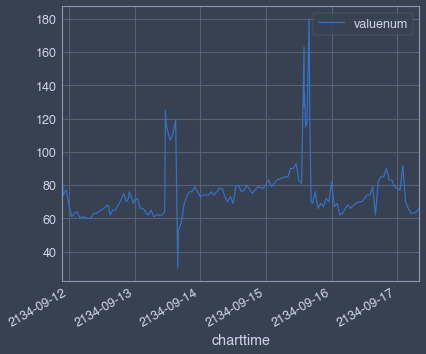

In [675]:
df[df['itemid']==211].iloc[:137].plot(kind='line', x='charttime', y='valuenum')

In [44]:
df.iloc[0]['charttime'] + pd.to_timedelta(10, 'h')

Timestamp('2134-09-15 23:55:00')

In [676]:
x=df[
    (df['itemid']==211) &
    (df['charttime'] < (df.iloc[240]['charttime'] + pd.to_timedelta(10, 'h'))) &
    (df['charttime'] > df.iloc[240]['charttime'])
]['timestamp']

In [678]:
x

241    5.197616e+09
244    5.197617e+09
246    5.197619e+09
248    5.197622e+09
250    5.197622e+09
252    5.197624e+09
254    5.197626e+09
256    5.197630e+09
257    5.197633e+09
260    5.197637e+09
262    5.197640e+09
264    5.197644e+09
266    5.197648e+09
Name: timestamp, dtype: float64

### SciPy Interp1D Test

In [ ]:
f = interp1d(
    x=x,
    y=df.iloc[x.index],
    fill_value="extrapolate",
    kind='cubic',
)
y = f(np.linspace(
    x.iloc[0],
    x.iloc[-1],
    1000
))
fig, ax = plt.subplots(figsize=(16, 9))
# sns.lineplot(data=df.iloc[x.index], x='charttime', y='valuenum', ax=ax)
ax.plot_date(data=df.iloc[x.index], x='charttime', y='valuenum')
sns.lineplot(x=pd.date_range(
    start=df.iloc[x.index[0]]['charttime'],
    end=df.iloc[x.index[-1]]['charttime'],
    periods=2
), y=[90, 90], ax=ax)
sns.lineplot(
    x=np.linspace(x.iloc[0], x.iloc[-1], 1000, dtype='datetime64[s]'), y=y, ax=ax
)

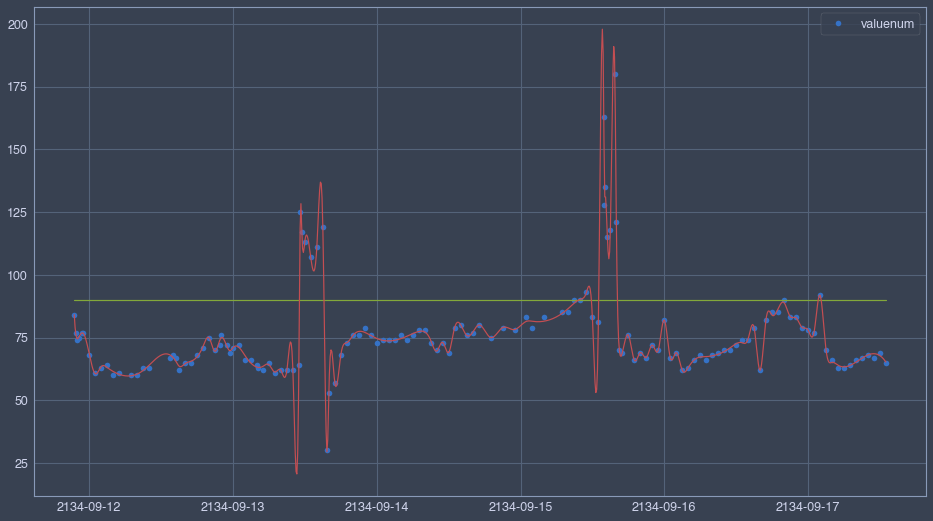

In [679]:
x=df[df['itemid']==211]['timestamp'].iloc[:142]
f = UnivariateSpline(
    x=x,
    y=df.iloc[x.index]['valuenum'],
#     fill_value="extrapolate",
#     kind='cubic',
#     s=1/(2**0.5),
)
y = f(np.linspace(
    x.iloc[0],
    x.iloc[-1],
    1000
))
fig, ax = plt.subplots(figsize=(16, 9))
# sns.lineplot(data=df.iloc[x.index], x='charttime', y='valuenum', ax=ax)
ax.plot_date(data=df.iloc[x.index], x='charttime', y='valuenum')
sns.lineplot(x=pd.date_range(
    start=df.iloc[x.index[0]]['charttime'],
    end=df.iloc[x.index[-1]]['charttime'],
    periods=2
), y=[90, 90], ax=ax)
sns.lineplot(
    x=np.linspace(x.iloc[0], x.iloc[-1], 1000, dtype='datetime64[s]'), y=y, ax=ax
)

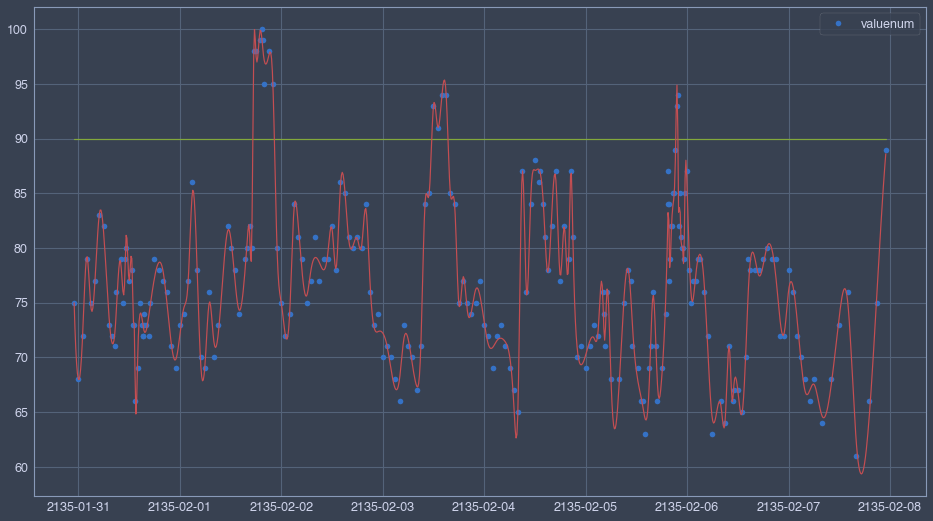

In [680]:
x=df[df['itemid']==211]['timestamp'].iloc[143:]
f = UnivariateSpline(
    x=x,
    y=df.iloc[x.index]['valuenum'],
#     fill_value="extrapolate",
#     kind='cubic',
#     s=1/(2**0.5),
)
y = f(np.linspace(
    x.iloc[0],
    x.iloc[-1],
    1000
))
fig, ax = plt.subplots(figsize=(16, 9))
# sns.lineplot(data=df.iloc[x.index], x='charttime', y='valuenum', ax=ax)
ax.plot_date(data=df.iloc[x.index], x='charttime', y='valuenum')
sns.lineplot(x=pd.date_range(
    start=df.iloc[x.index[0]]['charttime'],
    end=df.iloc[x.index[-1]]['charttime'],
    periods=2
), y=[90, 90], ax=ax)
sns.lineplot(
    x=np.linspace(x.iloc[0], x.iloc[-1], 1000, dtype='datetime64[s]'), y=y, ax=ax
)

### Kriging Test

Adjusting data for anisotropy...
Initializing variogram model...
Using 'gaussian' Variogram Model
Partial Sill: 326.8130965224553
Full Sill: 382.5404933648543
Range: 13699.105582726534
Nugget: 55.727396842399024 

Calculating statistics on variogram model fit...
Q1 = 0.04417956347094552
Q2 = 1.7142794042256992
cR = 312.2560092984649 

Initializing drift terms...
Executing Universal Kriging...



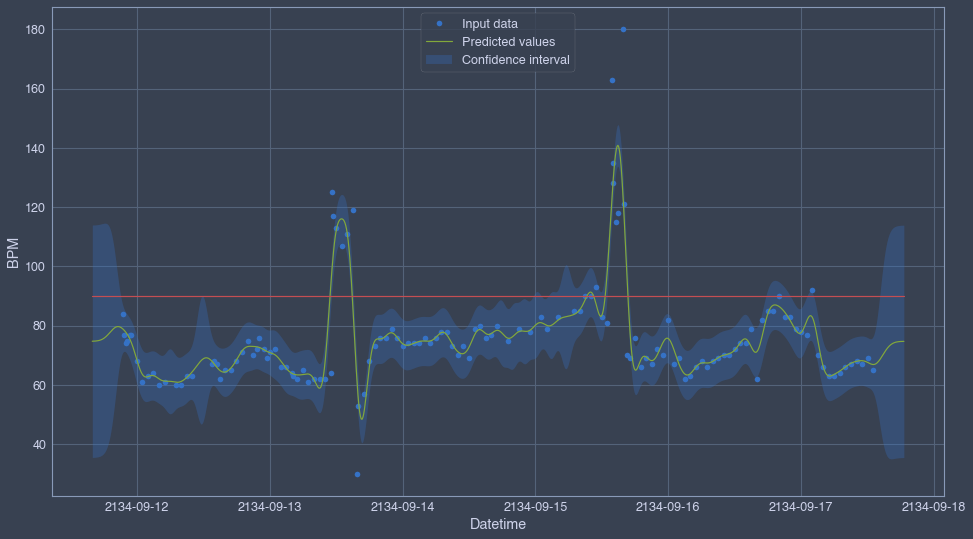

In [681]:
x=df[df['itemid']==211]['timestamp'].iloc[:142]
x_pred = np.linspace(x.iloc[0]-2e4, x.iloc[-1]+2e4, 1000)
uk = UniversalKriging(
    x,
    np.zeros(x.shape),
    df.iloc[x.index]['valuenum'],
    variogram_model='gaussian',
#     nlags=7,
#     enable_plotting=True,
    verbose=True
)
y_pred, y_std = uk.execute('grid', x_pred, np.array([0.]))

y_pred = np.squeeze(y_pred)
y_std = np.squeeze(y_std)

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.plot_date(x.astype('datetime64[s]'), df.iloc[x.index]['valuenum'], label='Input data')

ax.plot(
    x_pred.astype('datetime64[s]'),
    y_pred, 
    label='Predicted values'
)
ax.fill_between(
    x_pred.astype('datetime64[s]'),
    y_pred - 0.1*y_std, y_pred + 0.1*y_std,
    alpha=0.3,
    label='Confidence interval'
)
sns.lineplot(np.array([x.iloc[0]-2e4, x.iloc[-1]+2e4]).astype('datetime64[s]'), y=[90, 90])
ax.legend(loc=9)
ax.set_xlabel('Datetime')
ax.set_ylabel('BPM')
if 'CI' not in os.environ:
    # skip in continous integration
    plt.show()

Adjusting data for anisotropy...
Initializing variogram model...
Using 'gaussian' Variogram Model
Partial Sill: 18.19834860821685
Full Sill: 57.51442745582051
Range: 7583.134239139821
Nugget: 39.316078847603656 

Calculating statistics on variogram model fit...
Q1 = 0.0428182650540706
Q2 = 0.7421237238118147
cR = 41.41908097272696 

Initializing drift terms...
Executing Universal Kriging...



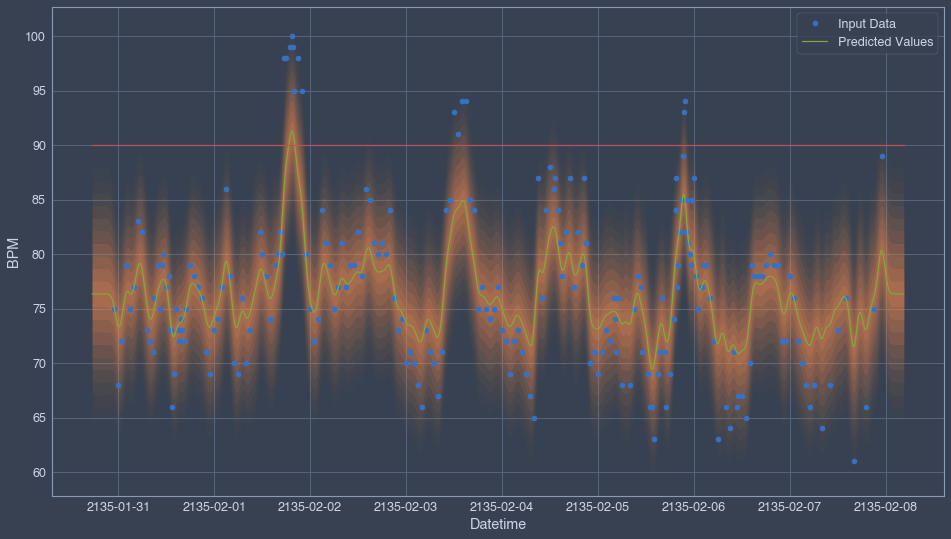

In [697]:
x=df[df['itemid']==211]['timestamp'].iloc[143:]
x_pred = np.linspace(x.iloc[0]-2e4, x.iloc[-1]+2e4, 1000)
uk = UniversalKriging(
    x,
    np.zeros(x.shape),
    df.iloc[x.index]['valuenum'],
    variogram_model='gaussian',
#     nlags=7,
#     enable_plotting=True,
    verbose=True
)
y_pred, y_std = uk.execute('grid', x_pred, np.array([0.]))

y_pred = np.squeeze(y_pred)
y_std = np.squeeze(y_std)

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.plot_date(x.astype('datetime64[s]'), df.iloc[x.index]['valuenum'], label='Input data')

ax.plot(
    x_pred.astype('datetime64[s]'),
    y_pred, 
    label='Predicted values'
)
for i in range(10):
    ax.fill_between(
        x_pred.astype('datetime64[s]'),
        y_pred - 0.02*y_std*(i+1), y_pred + 0.02*y_std*(i+1),
        alpha=0.15 * (10-i)/10,
        label='Confidence interval',
        color='y'
    )
sns.lineplot(np.array([x.iloc[0]-2e4, x.iloc[-1]+2e4]).astype('datetime64[s]'), y=[90, 90])
ax.legend(['Input Data', 'Predicted Values'])
ax.set_xlabel('Datetime')
ax.set_ylabel('BPM')
if 'CI' not in os.environ:
    # skip in continous integration
    plt.show()

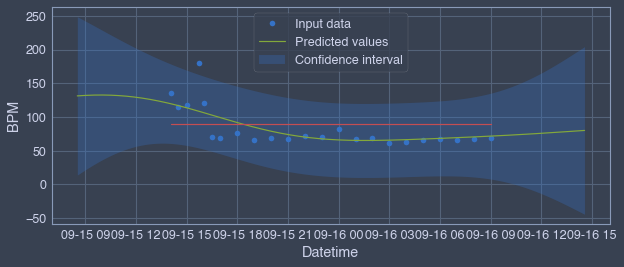

In [705]:
x=df[
    (df['itemid']==211) &
    (df['charttime'] < (df.iloc[240]['charttime'] + pd.to_timedelta(20, 'h'))) &
    (df['charttime'] > df.iloc[240]['charttime'])
]['timestamp']
uk = UniversalKriging(
    x,
    np.zeros(x.shape),
    df.iloc[x.index]['valuenum'],
    variogram_model='gaussian',
    nlags=7,
#     enable_plotting=True
)
y_pred, y_std = uk.execute('grid', np.linspace(x.iloc[0]-2e4, x.iloc[-1]+2e4, 1000), np.array([0.]))

y_pred = np.squeeze(y_pred)
y_std = np.squeeze(y_std)
# 
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot_date(x.astype('datetime64[s]'), df.iloc[x.index]['valuenum'], label='Input data')

ax.plot(
    np.linspace(x.iloc[0]-2e4, x.iloc[-1]+2e4, 1000, dtype='datetime64[s]'),
    y_pred, 
    label='Predicted values'
)
ax.fill_between(
    np.linspace(x.iloc[0]-2e4, x.iloc[-1]+2e4, 1000, dtype='datetime64[s]'),
    y_pred - 0.1*y_std, y_pred + 0.1*y_std,
    alpha=0.3,
    label='Confidence interval'
)
sns.lineplot(x=pd.date_range(
    start=df.iloc[x.index[0]]['charttime'],
    end=df.iloc[x.index[-1]]['charttime'],
    periods=2
), y=[90, 90], ax=ax)
ax.legend(loc=9)
ax.set_xlabel('Datetime')
ax.set_ylabel('BPM')
if 'CI' not in os.environ:
    # skip in continous integration
    plt.show()

R^2 Score: 0.670770342654817
Initial Kernel: 1**2 * Matern(length_scale=1e+06, nu=1.5) + WhiteKernel(noise_level=100)
Optimised: 62.8**2 * Matern(length_scale=7.23e+04, nu=1.5) + WhiteKernel(noise_level=72.2)
LML: -1434.6703135505406


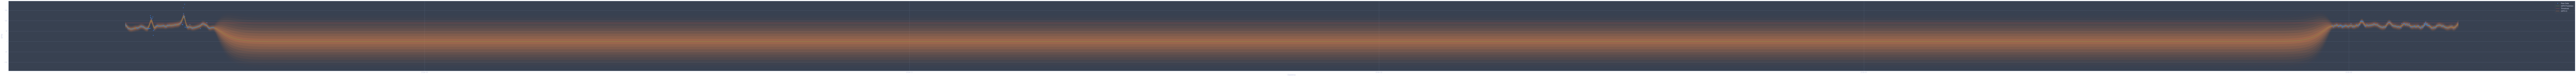

In [922]:
# --GPR + Kernel--
# x = df[df['itemid']==211]['timestamp'].iloc[143:]
x = df[df['itemid']==211]['timestamp']
kernel = 1.0 * Matern(length_scale=1e6, length_scale_bounds=(1e3, 1e9)) \
    + WhiteKernel(noise_level=1e2, noise_level_bounds=(1e-3, 1e+4))
gpr = GaussianProcessRegressor(
    kernel=kernel,
    random_state=42,
    n_restarts_optimizer=50
).fit(x.to_numpy().reshape(-1, 1), df.iloc[x.index]['valuenum'])
print("R^2 Score: %s\nInitial Kernel: %s\nOptimised: %s\nLML: %s" % (
        gpr.score(x.to_numpy().reshape(-1, 1), df.iloc[x.index]['valuenum']),
        kernel,
        gpr.kernel_,
        gpr.log_marginal_likelihood(gpr.kernel_.theta)
    )
)
# Predictions
x_pred = np.linspace(x.iloc[0]-3e3, x.iloc[-1]+3e3, 1e5).reshape(-1, 1)
y_pred, y_std = gpr.predict(x_pred, return_std=True)
# --Plotting--
fig, ax = plt.subplots(figsize=(320, 9))
# Raw Data
ax.plot_date(data=df.iloc[x.index], x='charttime', y='valuenum')
# Predicted Values
ax.plot(
    x_pred.astype('datetime64[s]'),
    y_pred, 
    label='Predicted values'
)
# Confidence Interval
for i in range(10):
    ax.fill_between(
        x_pred.astype('datetime64[s]').flatten(),
        y_pred - .2*y_std*(i+1), y_pred + .2*y_std*(i+1),
        alpha=0.125 * (10-i)/10,
        label='Confidence interval',
        color='y'
    )
# Threshold
sns.lineplot(np.array([x.iloc[0]-3e3, x.iloc[-1]+3e3]).astype('datetime64[s]'), y=[90, 90], ax=ax)
ax.legend(['Raw Data', 'GPR Prediction', 'Threshold', 'GPR CI'])
ax.set_xlabel('Datetime')
ax.set_ylabel('BPM')
if 'CI' not in os.environ:
    # skip in continous integration
    plt.show()

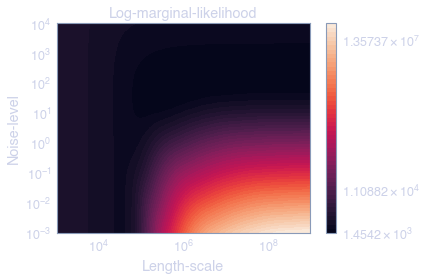

In [921]:
from matplotlib.colors import LogNorm

plt.figure()
theta0 = np.logspace(3, 9, 50)
theta1 = np.logspace(-3, 4, 50)
Theta0, Theta1 = np.meshgrid(theta0, theta1)
LML = [[gpr.log_marginal_likelihood(np.log([1e6, Theta0[i, j], Theta1[i, j]]))
        for i in range(Theta0.shape[0])] for j in range(Theta0.shape[1])]
LML = np.array(LML).T

vmin = (-LML).min()
vmax = (-LML).max()
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), 50), decimals=1)
plt.contourf(Theta0, Theta1, -LML,
            levels=level, norm=LogNorm(vmin=vmin, vmax=vmax))
# plt.contour(Theta0, Theta1, -LML,
#             levels=level, norm=LogNorm(vmin=vmin, vmax=vmax))
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Length-scale")
plt.ylabel("Noise-level")
plt.title("Log-marginal-likelihood")
plt.tight_layout()

plt.show()

## Comparison of Methods

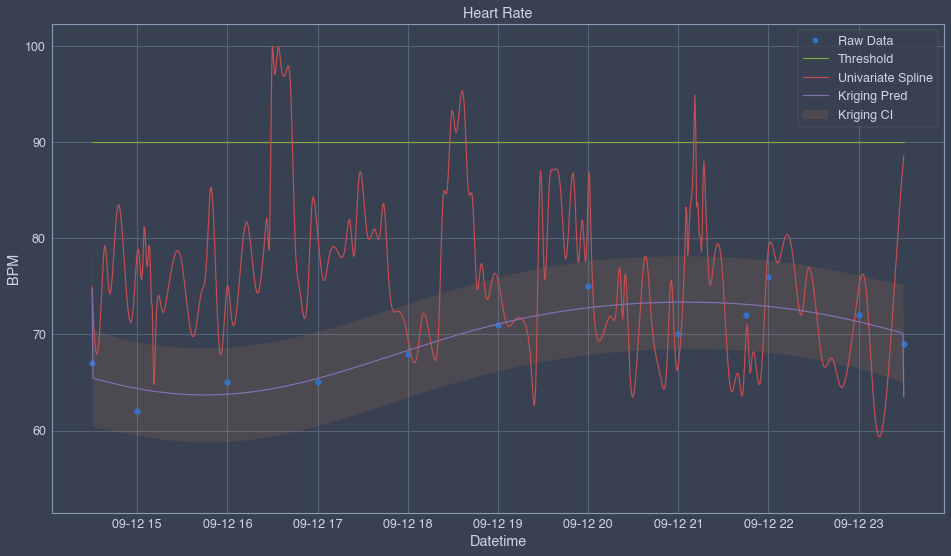

In [644]:
fig, ax = plt.subplots(figsize=(16, 9))
# sns.lineplot(data=df.iloc[x.index], x='charttime', y='valuenum', ax=ax)
ax.plot_date(data=df.iloc[x.index], x='charttime', y='valuenum')
sns.lineplot(x=pd.date_range(
    start=df.iloc[x.index[0]]['charttime'],
    end=df.iloc[x.index[-1]]['charttime'],
    periods=2
), y=[90, 90], ax=ax)
sns.lineplot(
    x=np.linspace(x.iloc[0], x.iloc[-1], 1000, dtype='datetime64[s]'), y=y, ax=ax
)
ax.plot(
    np.linspace(x.iloc[0], x.iloc[-1], 1000, dtype='datetime64[s]'),
    y_pred, 
    label='Predicted values'
)
ax.fill_between(
    np.linspace(x.iloc[0], x.iloc[-1], 1000, dtype='datetime64[s]'),
    y_pred - 2*y_std, y_pred + 2*y_std,
    alpha=0.1,
    label='Confidence interval',
    color='y'
)

ax.set_xlabel('Datetime')
ax.set_ylabel('BPM')
ax.set_title('Heart Rate')
ax.legend(['Raw Data', 'Threshold', 'Univariate Spline', 'Kriging Pred', 'Kriging CI'])

Adjusting data for anisotropy...
Initializing variogram model...
Using 'gaussian' Variogram Model
Partial Sill: 18.19834860821685
Full Sill: 57.51442745582051
Range: 7583.134239139821
Nugget: 39.316078847603656 

Calculating statistics on variogram model fit...
Q1 = 0.0428182650540706
Q2 = 0.7421237238118147
cR = 41.41908097272696 

Initializing drift terms...
Executing Universal Kriging...



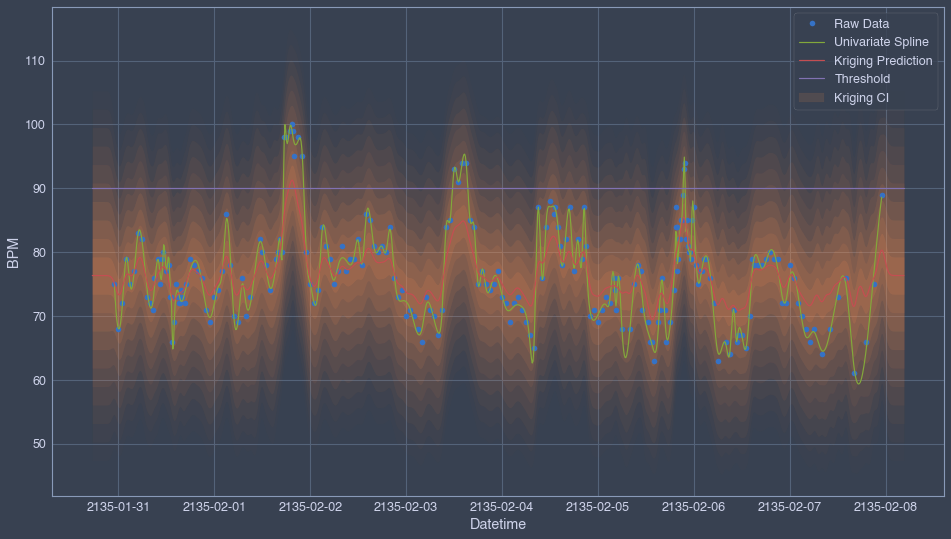

In [700]:
x=df[df['itemid']==211]['timestamp'].iloc[143:]
f = UnivariateSpline(
    x=x,
    y=df.iloc[x.index]['valuenum'],
#     fill_value="extrapolate",
#     kind='cubic',
#     s=1/(2**0.5),
)
y = f(np.linspace(
    x.iloc[0],
    x.iloc[-1],
    1000
))
fig, ax = plt.subplots(figsize=(16, 9))
# sns.lineplot(data=df.iloc[x.index], x='charttime', y='valuenum', ax=ax)
ax.plot_date(data=df.iloc[x.index], x='charttime', y='valuenum')
sns.lineplot(
    x=np.linspace(x.iloc[0], x.iloc[-1], 1000, dtype='datetime64[s]'), y=y, ax=ax
)
x_pred = np.linspace(x.iloc[0]-2e4, x.iloc[-1]+2e4, 1000)
uk = UniversalKriging(
    x,
    np.zeros(x.shape),
    df.iloc[x.index]['valuenum'],
    variogram_model='gaussian',
#     nlags=7,
#     enable_plotting=True,
    verbose=True
)
y_pred, y_std = uk.execute('grid', x_pred, np.array([0.]))

y_pred = np.squeeze(y_pred)
y_std = np.squeeze(y_std)

ax.plot(
    x_pred.astype('datetime64[s]'),
    y_pred, 
    label='Predicted values'
)
for i in range(10):
    ax.fill_between(
        x_pred.astype('datetime64[s]'),
        y_pred - 0.05*y_std*(i+1), y_pred + 0.05*y_std*(i+1),
        alpha=0.125 * (10-i)/10,
        label='Confidence interval',
        color='y'
    )
sns.lineplot(np.array([x.iloc[0]-2e4, x.iloc[-1]+2e4]).astype('datetime64[s]'), y=[90, 90], ax=ax)
ax.legend(['Raw Data', 'Univariate Spline', 'Kriging Prediction', 'Threshold', 'Kriging CI'])
ax.set_xlabel('Datetime')
ax.set_ylabel('BPM')
if 'CI' not in os.environ:
    # skip in continous integration
    plt.show()

0.8277507806636768


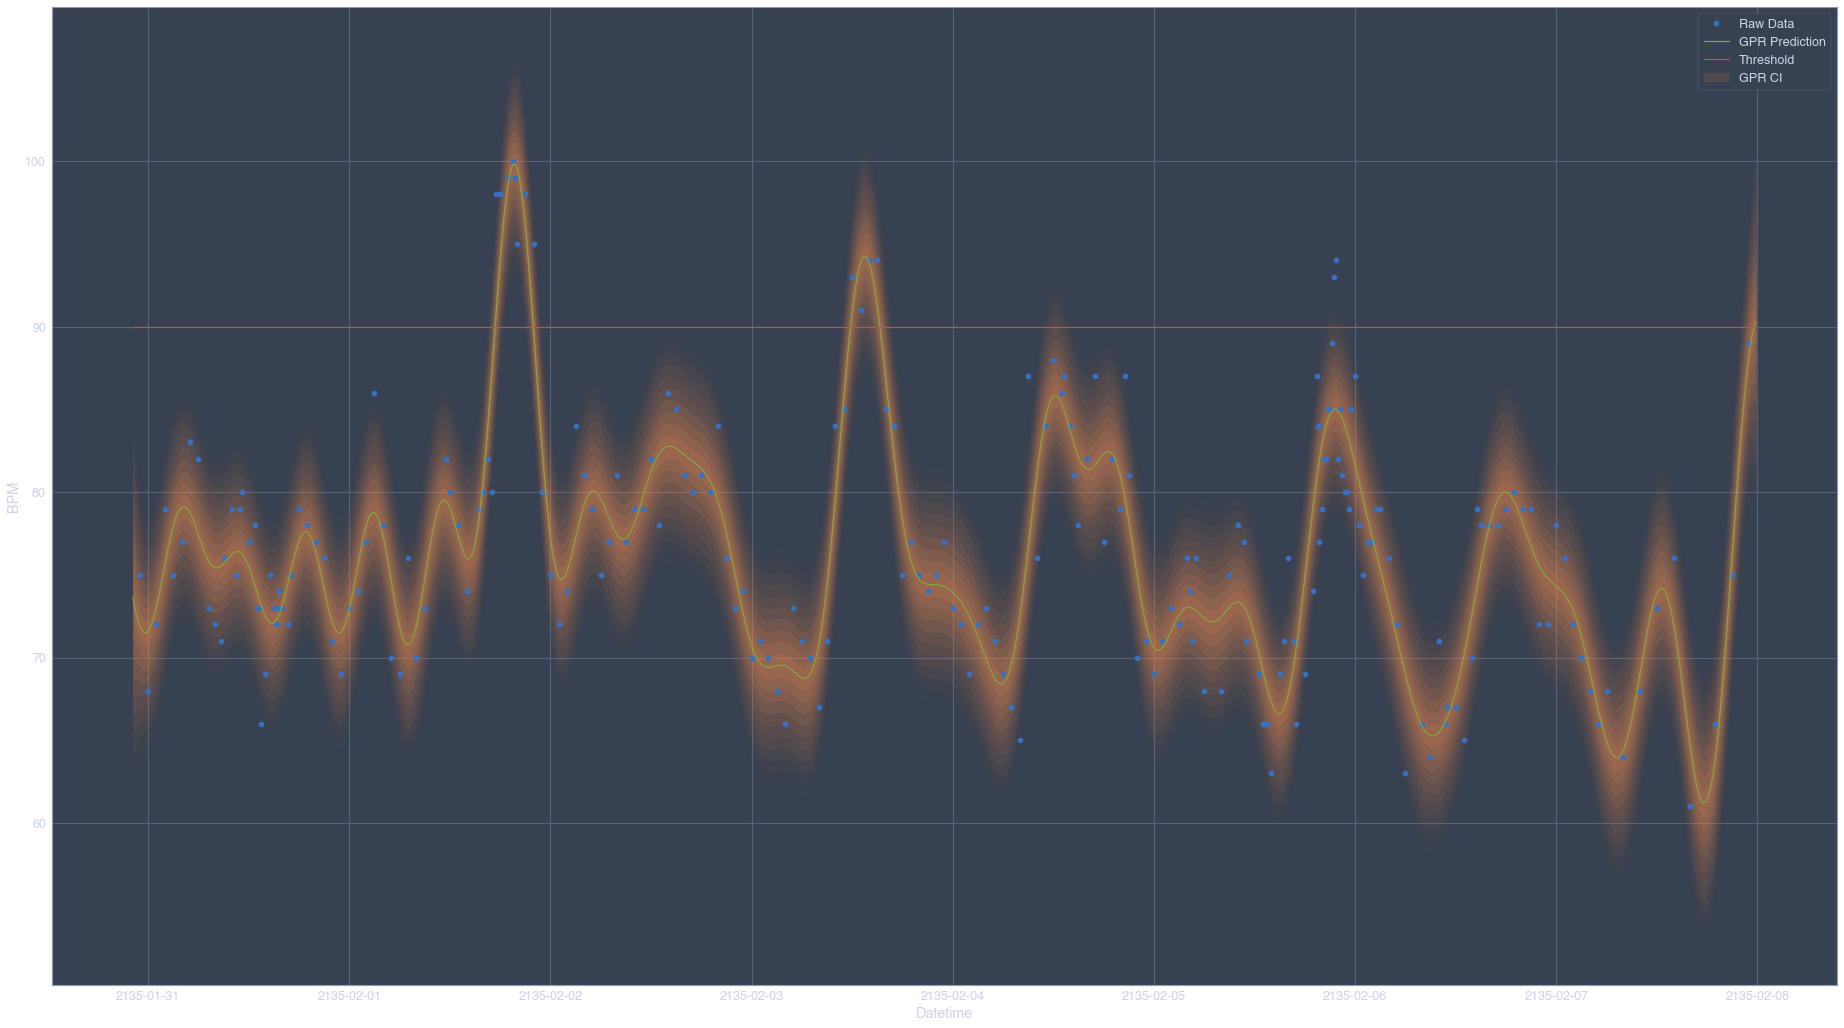

In [840]:
# --GPR + Kernel--
x = df[df['itemid']==211]['timestamp'].iloc[143:]
gpr = GaussianProcessRegressor(
    kernel=1.0 * RBF(length_scale=1e7, length_scale_bounds=(1e3, 1e7)) \
    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1)),
    random_state=42,
    n_restarts_optimizer=9
).fit(x.to_numpy().reshape(-1, 1), df.iloc[x.index]['valuenum'])
print(gpr.score(x.to_numpy().reshape(-1, 1), df.iloc[x.index]['valuenum']))
# Predictions
x_pred = np.linspace(x.iloc[0]-3e3, x.iloc[-1]+3e3, 2000).reshape(-1, 1)
y_pred, y_std = gpr.predict(x_pred, return_std=True)
# --Plotting--
fig, ax = plt.subplots(figsize=(32, 18))
# Raw Data
ax.plot_date(data=df.iloc[x.index], x='charttime', y='valuenum')
# Predicted Values
ax.plot(
    x_pred.astype('datetime64[s]'),
    y_pred, 
    label='Predicted values'
)
# Confidence Interval
for i in range(10):
    ax.fill_between(
        x_pred.astype('datetime64[s]').flatten(),
        y_pred - .2*y_std*(i+1), y_pred + .2*y_std*(i+1),
        alpha=0.125 * (10-i)/10,
        label='Confidence interval',
        color='y'
    )
# Threshold
sns.lineplot(np.array([x.iloc[0]-3e3, x.iloc[-1]+3e3]).astype('datetime64[s]'), y=[90, 90], ax=ax)
ax.legend(['Raw Data', 'GPR Prediction', 'Threshold', 'GPR CI'])
ax.set_xlabel('Datetime')
ax.set_ylabel('BPM')
if 'CI' not in os.environ:
    # skip in continous integration
    plt.show()

0.8277507806636768


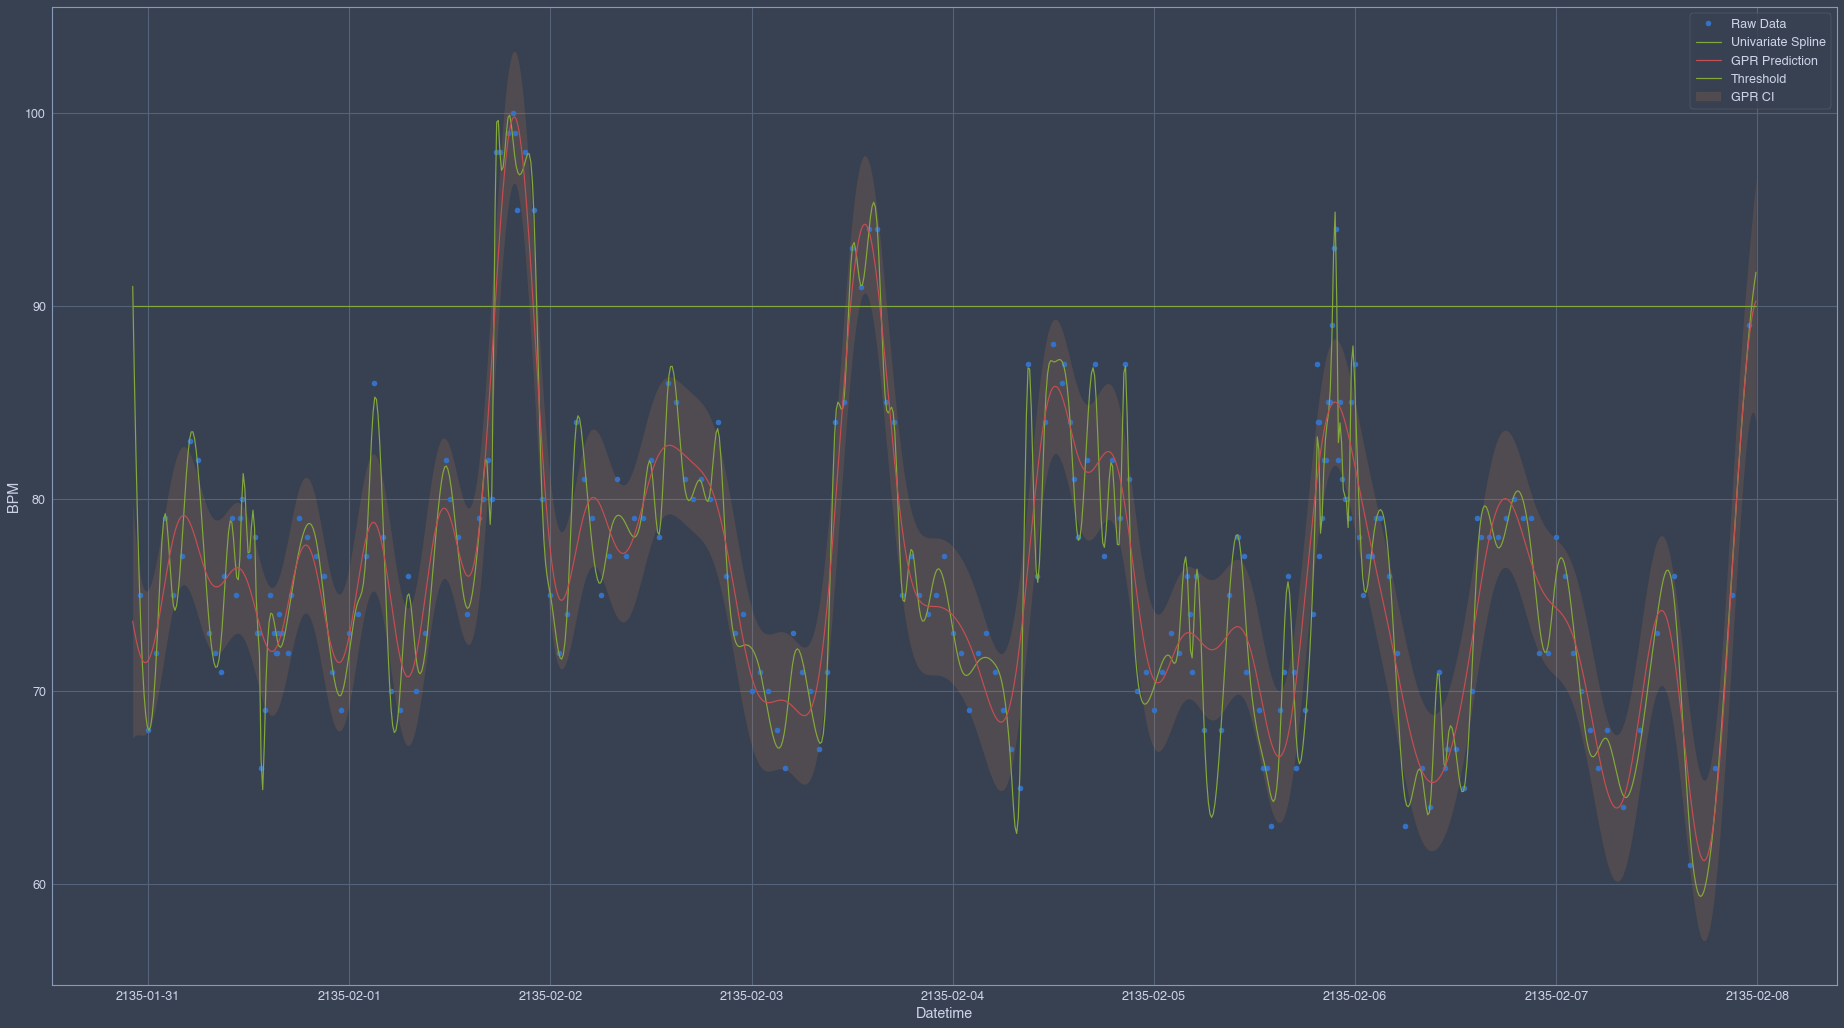

In [861]:
# --GPR + Kernel--
x = df[df['itemid']==211]['timestamp'].iloc[143:]
gpr = GaussianProcessRegressor(
    kernel=1.0 * RBF(length_scale=1e7, length_scale_bounds=(1e3, 1e7)) \
    + WhiteKernel(noise_level=.1, noise_level_bounds=(1e-10, 1e+1)),
    random_state=42,
    n_restarts_optimizer=9
).fit(x.to_numpy().reshape(-1, 1), df.iloc[x.index]['valuenum'])
print(gpr.score(x.to_numpy().reshape(-1, 1), df.iloc[x.index]['valuenum']))
# Predictions
x_pred = np.linspace(x.iloc[0]-3e3, x.iloc[-1]+3e3, 2000).reshape(-1, 1)
y_pred, y_std = gpr.predict(x_pred, return_std=True)
# --Univariate Spline--
f = UnivariateSpline(
    x=x,
    y=df.iloc[x.index]['valuenum'],
#     fill_value="extrapolate",
#     kind='cubic',
#     s=1/(2**0.5),
)
y = f(np.linspace(
    x.iloc[0]-3e3,
    x.iloc[-1]+3e3,
    1000
))
# --Plotting--
fig, ax = plt.subplots(figsize=(32, 18))
# Raw Data
ax.plot_date(data=df.iloc[x.index], x='charttime', y='valuenum')
# Univariate Spline
sns.lineplot(
    x=np.linspace(x.iloc[0]-3e3, x.iloc[-1]+3e3, 1000, dtype='datetime64[s]'),
    y=y,
    ax=ax,
    color='g'
)
# GPR
# - Predicted Values
ax.plot(
    x_pred.astype('datetime64[s]'),
    y_pred, 
    label='Predicted values',
    color='r'
)
# - Confidence Interval
# for i in range(10):
#     ax.fill_between(
#         x_pred.astype('datetime64[s]').flatten(),
#         y_pred - 1*y_std*(i+1), y_pred + 1*y_std*(i+1),
#         alpha=0.125 * (10-i)/10,
#         label='Confidence interval',
#         color='y'
#     )
ax.fill_between(
    x_pred.astype('datetime64[s]').flatten(),
    y_pred - 1*y_std, y_pred + 1*y_std,
    alpha=0.125,
    label='Confidence interval',
    color='y'
)
# Threshold
sns.lineplot(
    np.array([x.iloc[0]-3e3, x.iloc[-1]+3e3]).astype('datetime64[s]'),
    y=[90, 90],
    ax=ax
)
ax.legend(['Raw Data', 'Univariate Spline', 'GPR Prediction', 'Threshold', 'GPR CI'])
ax.set_xlabel('Datetime')
ax.set_ylabel('BPM')
if 'CI' not in os.environ:
    # skip in continous integration
    plt.show()

## Find all patients with required records

In [709]:
query = query_schema + """
SELECT DISTINCT subject_id
FROM sepsis_patient_diagnoses
ORDER BY subject_id
"""
df = pd.read_sql_query(query,con)

df

,subject_id
0,3
1,21
2,33
3,38
4,61
...,...
5543,99836
5544,99865
5545,99912
5546,99985


In [710]:
cur = con.cursor()
for subject_id in df['subject_id']:
    print(f'{subject_id}', end=' ')
    q = query_schema + """
    SELECT *
    FROM sepsis_patient_chartevents
    WHERE subject_id = {}
    """.format(subject_id)
    subject_events = pd.read_sql_query(q,con)
    if itemid_present_check(subject_events):
        insert_q = query_schema + """
        INSERT INTO sepsis_patients_with_records
        VALUES ({})
        """.format(subject_id)
        cur.execute(insert_q)
        eligible_subjects.append(subject_id)
con.commit()
cur.close()

3 Requirements met.
21 Requirements met.
33 Requirements met.
38 Requirements met.
61 Requirements met.
62 Requirements met.
64 Requirements met.
85 Requirements met.
105 Requirements met.
111 Requirements met.
112 Requirements met.
117 Requirements met.
124 Requirements met.
145 Requirements met.
157 Requirements met.
166 Requirements met.
177 Requirements met.
187 Requirements met.
188 Requirements met.
191 Requirements met.
195 Requirements met.
202 Requirements met.
211 Requirements met.
213 Requirements met.
223 Requirements met.
226 Requirements met.
234 Requirements met.
250 Requirements met.
261 Requirements met.
268 Requirements met.
269 Requirements met.
275 Requirements met.
279 Requirements met.
292 Requirements met.
305 Requirements met.
323 Requirements met.
329 Requirements met.
353 Requirements met.
357 Requirements met.
366 Requirements met.
394 Requirements met.
395 Requirements met.
402 Requirements met.
405 Requirements met.
406 Requirements met.
408 Requirements me

3330 Requirements met.
3338 Requirements met.
3344 Requirements met.
3356 Requirements met.
3369 Requirements met.
3370 Requirements met.
3372 Requirements met.
3386 Requirements met.
3389 Requirements met.
3390 Requirements met.
3392 Requirements met.
3393 Requirements met.
3400 Requirements met.
3426 Requirements met.
3433 Requirements met.
3456 Requirements met.
3474 Requirements met.
3482 Requirements met.
3486 Requirements met.
3491 Requirements met.
3506 Requirements met.
3513 Requirements met.
3516 Requirements met.
3521 Requirements met.
3526 Requirements met.
3542 Requirements met.
3564 Requirements met.
3567 Requirements met.
3588 Requirements met.
3593 Requirements met.
3598 Requirements met.
3602 Requirements met.
3619 Requirements met.
3632 Requirements met.
3647 Requirements met.
3649 Requirements met.
3652 Requirements met.
3676 Requirements met.
3677 Requirements met.
3683 Requirements met.
3694 Requirements met.
3700 Requirements met.
3705 Requirements met.
3706 Requir

6597 Requirements met.
6602 Requirements met.
6604 Requirements met.
6606 Requirements met.
6613 Requirements met.
6615 Requirements met.
6624 Requirements met.
6636 Requirements met.
6637 Requirements met.
6663 Requirements met.
6667 Requirements met.
6669 Requirements met.
6690 Requirements met.
6702 Requirements met.
6718 Requirements met.
6731 Requirements met.
6735 Requirements met.
6741 Requirements met.
6758 Requirements met.
6763 Requirements met.
6787 Requirements met.
6794 Requirements met.
6800 Requirements met.
6803 Requirements met.
6804 Requirements met.
6805 Requirements met.
6821 Requirements met.
6830 Requirements met.
6841 Requirements met.
6845 Requirements met.
6850 Requirements met.
6855 Requirements met.
6865 Requirements met.
6872 Requirements met.
6873 Requirements met.
6874 Requirements met.
6877 Requirements met.
6894 Requirements met.
6898 Requirements met.
6903 Requirements met.
6906 Requirements met.
6908 Requirements met.
6911 Requirements met.
6915 Requir

10038 Requirements met.
10045 Requirements met.
10056 Requirements met.
10057 Requirements met.
10059 Requirements met.
10061 Requirements met.
10076 Requirements met.
10088 Requirements met.
10094 Requirements met.
10124 Requirements met.
10130 Requirements met.
10132 Requirements met.
10139 Requirements met.
10144 Requirements met.
10152 Requirements met.
10160 Requirements met.
10174 Requirements met.
10185 Requirements met.
10186 Requirements met.
10188 Requirements met.
10207 Requirements met.
10236 Requirements met.
10246 Requirements met.
10264 Requirements met.
10274 Requirements met.
10277 Requirements met.
10280 Requirements met.
10288 Requirements met.
10299 Requirements met.
10302 Requirements met.
10304 Requirements met.
10311 Requirements met.
10327 Requirements met.
10353 Requirements met.
10356 Requirements met.
10368 Requirements met.
10370 Requirements met.
10377 Requirements met.
10391 Requirements met.
10408 Requirements met.
10412 Requirements met.
10417 Requiremen

16628 Requirements met.
16653 Requirements met.
16655 Requirements met.
16675 Requirements met.
16680 Requirements met.
16684 Requirements met.
16691 Requirements met.
16693 Requirements met.
16695 Requirements met.
16709 Requirements met.
16712 Requirements met.
16724 Requirements met.
16726 Requirements met.
16727 Requirements met.
16729 Requirements met.
16738 Requirements met.
16744 Requirements met.
16755 Requirements met.
16770 Requirements met.
16800 Requirements met.
16802 Requirements met.
16811 Requirements met.
16817 Requirements met.
16839 Requirements met.
16840 Requirements met.
16843 Requirements met.
16847 Requirements met.
16848 Requirements met.
16849 Requirements met.
16855 Requirements met.
16860 Requirements met.
16865 Requirements met.
16874 Requirements met.
16892 Requirements met.
16894 Requirements met.
16895 Requirements met.
16905 Requirements met.
16914 Requirements met.
16918 Requirements met.
16929 Requirements met.
16943 Requirements met.
16949 Requiremen

19729 Requirements met.
19731 Requirements met.
19754 Requirements met.
19755 Requirements met.
19768 Requirements met.
19793 Requirements met.
19799 Requirements met.
19823 Requirements met.
19827 Requirements met.
19839 Requirements met.
19851 Requirements met.
19855 Requirements met.
19869 Requirements met.
19885 Requirements met.
19891 Requirements met.
19897 Requirements met.
19898 Requirements met.
19911 Requirements met.
19928 Requirements met.
19940 Requirements met.
19986 Requirements met.
19991 Requirements met.
20006 Requirements met.
20009 Requirements met.
20071 Requirements met.
20086 Requirements met.
20088 Requirements met.
20101 Requirements met.
20124 Requirements met.
20131 Requirements met.
20132 Requirements met.
20133 Requirements met.
20143 Requirements met.
20155 Requirements met.
20192 Requirements met.
20199 Requirements met.
20204 Requirements met.
20210 Requirements met.
20248 Requirements met.
20249 Requirements met.
20254 Requirements met.
20276 Requiremen

23422 Requirements met.
23427 Requirements met.
23438 Requirements met.
23450 Requirements met.
23463 Requirements met.
23464 Requirements met.
23468 Requirements met.
23469 Requirements met.
23483 Requirements met.
23503 Requirements met.
23507 Requirements met.
23517 Requirements met.
23526 Requirements met.
23533 Requirements met.
23535 Requirements met.
23539 Requirements met.
23546 Requirements met.
23549 Requirements met.
23560 Requirements met.
23568 Requirements met.
23579 Requirements met.
23596 Requirements met.
23600 Requirements met.
23615 Requirements met.
23616 Requirements met.
23626 Requirements met.
23654 Requirements met.
23660 Requirements met.
23666 Requirements met.
23680 Requirements met.
23696 Requirements met.
23719 Requirements met.
23738 Requirements met.
23748 Requirements met.
23752 Requirements met.
23761 Requirements met.
23762 Requirements met.
23779 Requirements met.
23792 Requirements met.
23795 Requirements met.
23814 Requirements met.
23827 Requiremen

26688 Requirements met.
26701 Requirements met.
26702 Requirements met.
26709 Requirements met.
26710 Requirements met.
26716 Requirements met.
26721 Requirements met.
26724 Requirements met.
26734 Requirements met.
26737 Requirements met.
26749 Requirements met.
26771 Requirements met.
26774 Requirements met.
26788 Requirements met.
26791 Requirements met.
26795 Requirements met.
26818 Requirements met.
26825 Requirements met.
26828 Requirements met.
26839 Requirements met.
26848 Requirements met.
26861 Requirements met.
26868 Requirements met.
26885 Requirements met.
26887 Requirements met.
26896 Requirements met.
26912 Requirements met.
26916 Requirements met.
26927 Requirements met.
26930 Requirements met.
26931 Requirements met.
26953 Requirements met.
26958 Requirements met.
26967 Requirements met.
26978 Requirements met.
26980 Requirements met.
26999 Requirements met.
27005 Requirements met.
27043 Requirements met.
27049 Requirements met.
27051 Requirements met.
27053 Requiremen

40934 Requirements met.
40936 Requirements met.
40976 Requirements met.
40978 Requirements met.
41014 Requirements met.
41022 Requirements met.
41040 Requirements met.
41077 Requirements met.
41119 Requirements met.
41192 Requirements met.
41252 Requirements met.
41254 Requirements met.
41439 Requirements met.
41468 Requirements met.
41517 Requirements met.
41546 Requirements met.
41547 Requirements met.
41550 Requirements met.
41562 Requirements met.
41565 Requirements met.
41588 Requirements met.
41607 Requirements met.
41612 Requirements met.
41619 Requirements met.
41634 Requirements met.
41640 Requirements met.
41661 Requirements met.
41670 Requirements met.
41693 Requirements met.
41783 Requirements met.
41899 Requirements met.
41914 Requirements met.
41976 Requirements met.
42013 Requirements met.
42067 Requirements met.
42073 Requirements met.
42110 Requirements met.
42135 Requirements met.
42196 Requirements met.
42211 Requirements met.
42327 Requirements met.
42357 Requiremen

59039 Requirements met.
59067 Requirements met.
59085 Requirements met.
59101 Requirements met.
59113 Requirements met.
59152 Requirements met.
59194 Requirements met.
59260 Requirements met.
59285 Requirements met.
59301 Requirements met.
59347 Requirements met.
59442 Requirements met.
59472 Requirements met.
59498 Requirements met.
59516 Requirements met.
59603 Requirements met.
59618 Requirements met.
59726 Requirements met.
59777 Requirements met.
59801 Requirements met.
59832 Requirements met.
59877 Requirements met.
59903 Requirements met.
59936 Requirements met.
59943 Requirements met.
59950 Requirements met.
59976 Requirements met.
59979 Requirements met.
60054 Requirements met.
60077 Requirements met.
60106 Requirements met.
60115 Requirements met.
60118 Requirements met.
60122 Requirements met.
60142 Requirements met.
60174 Requirements met.
60204 Requirements met.
60214 Requirements met.
60244 Requirements met.
60262 Requirements met.
60274 Requirements met.
60337 Requiremen

68900 Requirements met.
68937 Requirements met.
68946 Requirements met.
68956 Requirements met.
68965 Requirements met.
69027 Requirements met.
69037 Requirements met.
69129 Requirements met.
69131 Requirements met.
69141 Requirements met.
69145 Requirements met.
69146 Requirements met.
69177 Requirements met.
69225 Requirements met.
69243 Requirements met.
69246 Requirements met.
69262 Requirements met.
69293 Requirements met.
69295 Requirements met.
69299 Requirements met.
69338 Requirements met.
69354 Requirements met.
69359 Requirements met.
69370 Requirements met.
69398 Requirements met.
69416 Requirements met.
69426 Requirements met.
69484 Requirements met.
69548 Requirements met.
69583 Requirements met.
69587 Requirements met.
69673 Requirements met.
69696 Requirements met.
69745 Requirements met.
69758 Requirements met.
69769 Requirements met.
69776 Requirements met.
69811 Requirements met.
69857 Requirements met.
69904 Requirements met.
69943 Requirements met.
70002 Requiremen

79423 Requirements met.
79511 Requirements met.
79523 Requirements met.
79553 Requirements met.
79594 Requirements met.
79596 Requirements met.
79617 Requirements met.
79645 Requirements met.
79651 Requirements met.
79664 Requirements met.
79671 Requirements met.
79699 Requirements met.
79709 Requirements met.
79754 Requirements met.
79851 Requirements met.
79862 Requirements met.
79894 Requirements met.
79909 Requirements met.
80024 Requirements met.
80030 Requirements met.
80033 Requirements met.
80111 Requirements met.
80121 Requirements met.
80218 Requirements met.
80260 Requirements met.
80274 Requirements met.
80319 Requirements met.
80342 Requirements met.
80386 Requirements met.
80473 Requirements met.
80518 Requirements met.
80536 Requirements met.
80538 Requirements met.
80580 Requirements met.
80592 Requirements met.
80603 Requirements met.
80644 Requirements met.
80649 Requirements met.
80656 Requirements met.
80658 Requirements met.
80696 Requirements met.
80737 Requiremen

99096 Requirements met.
99115 Requirements met.
99178 Requirements met.
99231 Requirements met.
99247 Requirements met.
99298 Requirements met.
99299 Requirements met.
99312 Requirements met.
99333 Requirements met.
99361 Requirements met.
99383 Requirements met.
99384 Requirements met.
99411 Requirements met.
99417 Requirements met.
99461 Requirements met.
99469 Requirements met.
99472 Requirements met.
99491 Requirements met.
99503 Requirements met.
99517 Requirements met.
99528 Requirements met.
99559 Requirements met.
99560 Requirements met.
99561 Requirements met.
99572 Requirements met.
99647 Requirements met.
99726 Requirements met.
99740 Requirements met.
99756 Requirements met.
99783 Requirements met.
99822 Requirements met.
99830 Requirements met.
99836 Requirements met.
99865 Requirements met.
99912 Requirements met.
99985 Requirements met.
99991 Requirements met.


## Detection of onset of Sepsis filtering

In [ ]:
itemid_sepsis_req = {
    'TempC' : [223762, 676],
    'TempF' : [223761, 678],
    'HR'    : [220045, 211],
    'RR'    : [220210, 224422, 224689, 224690, 618, 651, 615, 614],
    'PaCO2' : [220235, 778],
    'WBC'   : [51301]
}

In [ ]:
def onset_detection(df):
    n_symptoms = 0
    # tempC
    if any(id in itemid_sepsis_req['TempC'] and id in df['itemid']):
        